The main assumption of the AR approach is that the mean and variance of the time series remains constant. We may consider this to be a single regime in terms of mean and variance. In reality time series do not always present with constant regimes and series are often observed changing regimes. This necessitates the understanding and detection of underlying regimes to improve forecasting techniques.

There are a variety of approaches to understanding time series regimes. The approach presented in this Notebook is the use of a Markov Switching Autoregressive model for regime detection and classification. Furthermore, machine learning is explored for providing an expectation of the next day’s regime.

**Markov Switching Autoregression**

A Markov Switching model is a popular regime-switching model that rests on the assumption that unobserved states are determined by an underlying stochastic process known as a Markov-chain. A Markov-chain is a system describing possible events in which the probability of each event depends only on the state attained in the previous event. 

In [1]:
#!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Time Series Regime Analysis

This notebook explores time series regime analysis in python. Markov Switching Autoregressions (MS-AR) are used to detect and classify underlying states. A Random Forest Classifier is used to predict the next regime.

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

The first section deals with the MS-AR implementation for regime detection and classification. The second section deals with the machine learning, Random Forest Classifier, implementation for the prediction of the next regime.

## MS-AR

Importing our NASDAQ 100 dataset from Yahoo Finance, using the yfinance library. Displaying the data in a dataframe.

In [3]:
df = yf.download('^NDX', start="2010-01-01", end="2022-10-01", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1882.689941,1890.020020,1881.630005,1886.699951,1886.699951,1931380000
2010-01-05,1887.280029,1891.329956,1877.520020,1888.430054,1888.430054,2367860000
2010-01-06,1887.910034,1893.209961,1873.900024,1878.420044,1878.420044,2253340000
2010-01-07,1878.160034,1881.329956,1867.619995,1876.719971,1876.719971,2270050000
2010-01-08,1870.900024,1893.250000,1868.550049,1892.589966,1892.589966,2145390000


----------------------------------------------------------------
Plotting the adjusted close price to visualize the time series.

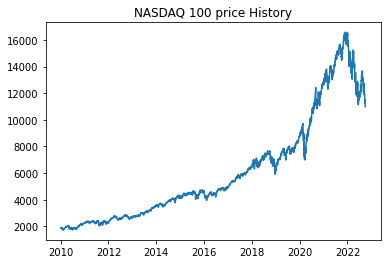

In [4]:
plt.title(f'NASDAQ 100 price History')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

------------------------
Creating and plotting price returns. Price returns are just the percentage change in price over 1 day.

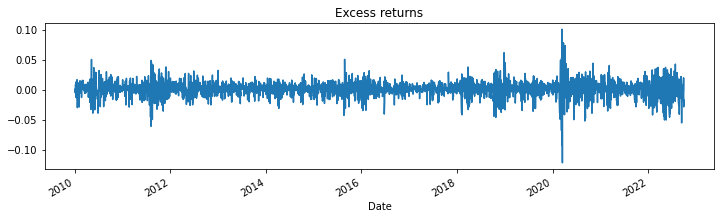

In [5]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

It shows in 2020 significant volatility during the covid -19 time

---------------------
Fitting the Markov regression model and viewing a summary output.

In [6]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                 3208
Model:               MarkovRegression   Log Likelihood                9874.471
Date:                Fri, 28 Oct 2022   AIC                         -19740.942
Time:                        03:54:43   BIC                         -19716.648
Sample:                             0   HQIC                        -19732.233
                               - 3208                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.562e-05   3.36e-06     19.546      0.000     5.9e-05    7.22e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   2.64e-05     15.825      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9864      0.003    283.463      0.000       0.980       0.993
p[1->0]        0.0315      0.008      4.030      0.000       0.016       0.047
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

-----------------
Viewing the smoothed probabilistic outputs from the fitted model. These are the models regime classifications on the dataset fitted. These probabilities are then plotted.

In [7]:
res_kns.smoothed_marginal_probabilities.head()

,0,1
Date,,
2010-01-05,0.936641,0.063359
2010-01-06,0.936989,0.063011
2010-01-07,0.929687,0.070313
2010-01-08,0.905970,0.094030
2010-01-11,0.866870,0.133130


In [8]:
print(res_kns.smoothed_marginal_probabilities.head())

                   0         1
Date                          
2010-01-05  0.936641  0.063359
2010-01-06  0.936989  0.063011
2010-01-07  0.929687  0.070313
2010-01-08  0.905970  0.094030
2010-01-11  0.866870  0.133130


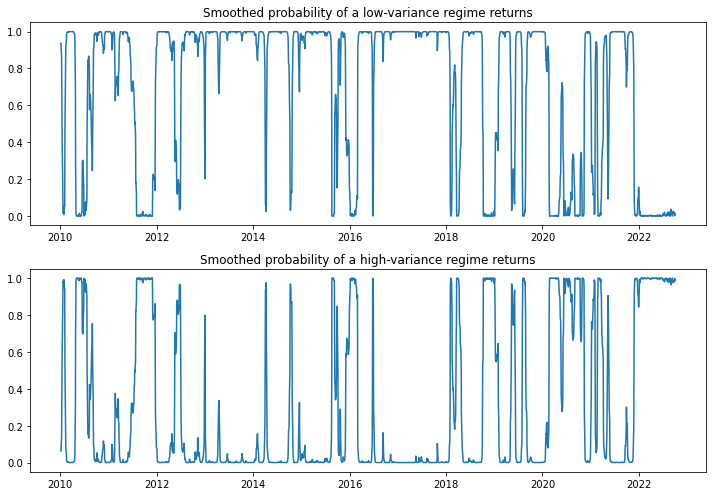

In [9]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

----------
Encoding regimes into binary states. 

0 --> low variance regime returns

1 --> high variance regime returns

In [10]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [11]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

------
Plotting the encoded states on the adjusted close price series of the NASDAQ 100, this gives a visual representation of the models regime classifications in time and price space.

Text(0.5, 0.98, 'Historical NASDAQ 100 regimes')

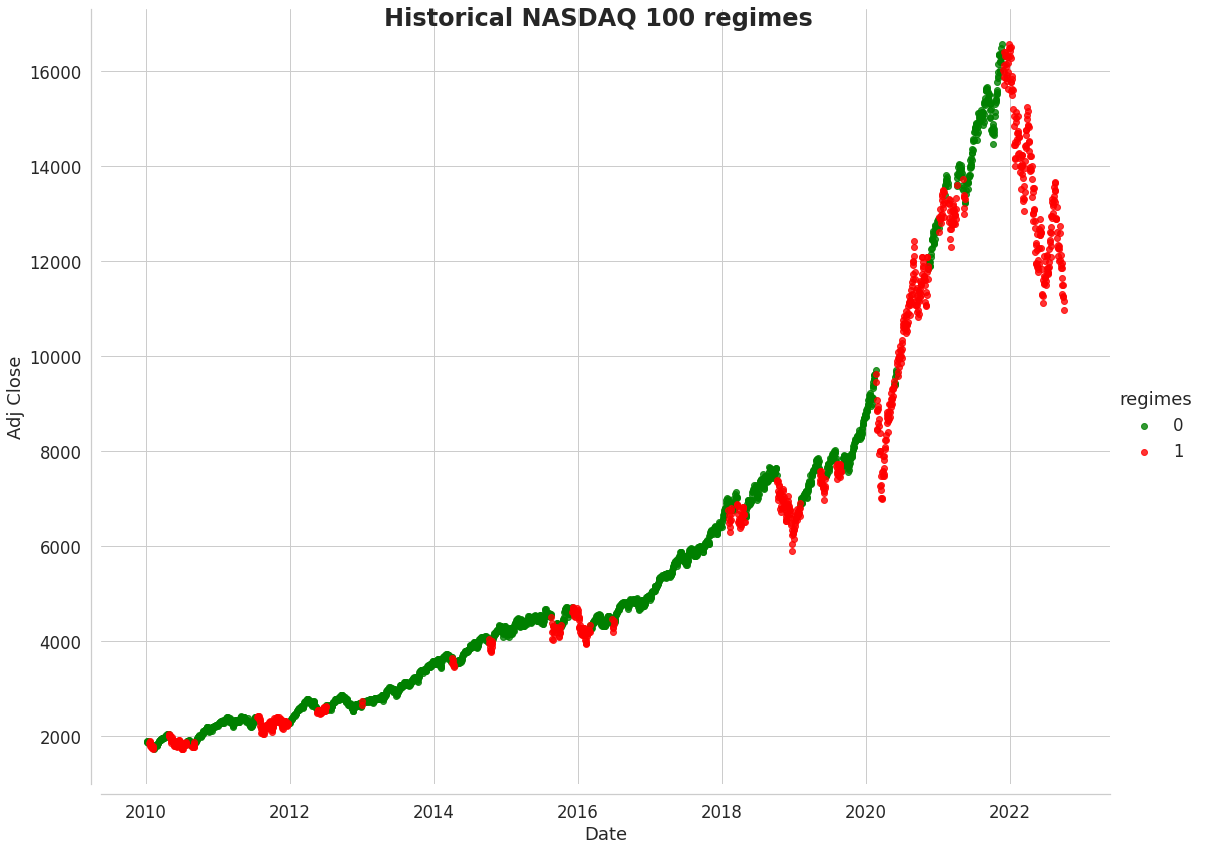

In [13]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical NASDAQ 100 regimes', fontsize=24, fontweight='demi')

## Machine learning

Loading the dataset and creating features for the random forest classifier.

In [14]:
ml_df = yf.download('^NDX', start="2010-01-01", end="2022-10-01", interval="1d")

# price and volume returns
for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)
ml_df.dropna(inplace=True)

# probabilities
low_var_prob = list(res_kns.smoothed_marginal_probabilities[0])
high_var_prob = list(res_kns.smoothed_marginal_probabilities[1])
ml_df['Low_Var_Prob'] = low_var_prob[len(low_var_prob)-len(ml_df):] # adjust length
ml_df['High_Var_Prob'] = high_var_prob[len(high_var_prob)-len(ml_df):]

# volatility     
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()
    
ml_df.dropna(inplace=True)

# states
ml_df['regimes'] = regime_list[len(regimes)-len(ml_df):] # adjust length

ml_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-04,1852.699951,1860.760010,1844.920044,1859.719971,1859.719971,2186020000,0.004402,-0.160357,0.004597,-0.228065,...,0.020904,0.046597,-0.114423,0.998196,0.001804,0.002106,0.005576,0.007032,0.010049,0
2010-03-05,1871.619995,1889.680054,1869.099976,1888.560059,1888.560059,2411880000,0.015508,0.103320,0.019978,-0.073604,...,0.078571,0.058195,0.047118,0.997182,0.002818,0.007847,0.006590,0.007716,0.010449,0
2010-03-08,1888.040039,1894.750000,1887.660034,1890.890015,1890.890015,2312310000,0.001234,-0.041283,0.016761,0.057772,...,0.115522,0.091114,-0.174585,0.998427,0.001573,0.007431,0.006455,0.007340,0.007453,0
2010-03-09,1885.989990,1911.380005,1885.989990,1901.380005,1901.380005,2620360000,0.005548,0.133222,0.006788,0.086439,...,0.245697,0.088917,-0.067852,0.998794,0.001206,0.007257,0.006342,0.007352,0.007420,0
2010-03-10,1901.239990,1920.660034,1901.109985,1917.349976,1917.349976,2554740000,0.008399,-0.025042,0.013993,0.104843,...,0.230121,0.105177,0.254611,0.998919,0.001081,0.003591,0.005194,0.007415,0.007067,0


------
Creating the data labels by shifting the current state back by one day. This brings the next days state into the current day, creating a future target state for the model to map to and predict.

In [15]:
ml_df['regimes'] = ml_df['regimes'].shift(-1) 
ml_df.dropna(inplace=True)
ml_df

,Open,High,Low,Close,Adj Close,Volume,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-04,1852.699951,1860.760010,1844.920044,1859.719971,1859.719971,2186020000,0.004402,-0.160357,0.004597,-0.228065,...,0.020904,0.046597,-0.114423,0.998196,0.001804,0.002106,0.005576,0.007032,0.010049,0.0
2010-03-05,1871.619995,1889.680054,1869.099976,1888.560059,1888.560059,2411880000,0.015508,0.103320,0.019978,-0.073604,...,0.078571,0.058195,0.047118,0.997182,0.002818,0.007847,0.006590,0.007716,0.010449,0.0
2010-03-08,1888.040039,1894.750000,1887.660034,1890.890015,1890.890015,2312310000,0.001234,-0.041283,0.016761,0.057772,...,0.115522,0.091114,-0.174585,0.998427,0.001573,0.007431,0.006455,0.007340,0.007453,0.0
2010-03-09,1885.989990,1911.380005,1885.989990,1901.380005,1901.380005,2620360000,0.005548,0.133222,0.006788,0.086439,...,0.245697,0.088917,-0.067852,0.998794,0.001206,0.007257,0.006342,0.007352,0.007420,0.0
2010-03-10,1901.239990,1920.660034,1901.109985,1917.349976,1917.349976,2554740000,0.008399,-0.025042,0.013993,0.104843,...,0.230121,0.105177,0.254611,0.998919,0.001081,0.003591,0.005194,0.007415,0.007067,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,11398.750000,11402.410156,11169.660156,11311.240234,11311.240234,5134350000,-0.016555,0.044316,-0.028059,0.148367,...,59.121194,-0.124372,0.317659,0.015801,0.984199,0.003365,0.009153,0.020198,0.019107,1.0
2022-09-26,11283.139648,11473.360352,11235.740234,11254.110352,11254.110352,4697730000,-0.005051,-0.085039,-0.021522,-0.044491,...,55.831962,-0.143756,0.095019,0.018335,0.981665,0.005838,0.008709,0.020187,0.018330,1.0
2022-09-27,11411.339844,11502.379883,11175.290039,11271.750000,11271.750000,4445050000,0.001567,-0.053788,-0.003491,-0.134253,...,53.500368,-0.105784,-0.014506,0.015463,0.984537,0.009243,0.009466,0.018976,0.016620,1.0


In [16]:
rf_df = ml_df.copy()
labels = rf_df.pop('regimes') # get target states into a variable
labels = labels.astype('int')

-----
Splitting the dataset into training and testing. Rebalancing the dataset by undersampling the smallest prediction category which is the low variance regime return.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(rf_df, labels, test_size=0.2)
Counter(y_train)

Counter({0: 1787, 1: 746})

In [18]:
# undersample our low_variance regime examples
under_sampler = RandomUnderSampler(random_state=40)
X_rs, y_rs = under_sampler.fit_resample(X_train, y_train)

In [19]:
Counter(y_rs)

Counter({0: 746, 1: 746})

------
Initializing and fitting the random forest classifier with 20 trees in the forest.

In [20]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_rs, y_rs)

RandomForestClassifier(n_estimators=20)

-----
Making predictions on the testing dataset. Two predictions are retrieved, the binary predicted state and the probabilistic state prediction.

In [21]:
y_pred = rf.predict(X_test)
y_prob_pred = rf.predict_proba(X_test)

-----
Assessing the models accuracy using an accuracy score, area under curve, false positive rate and true positive rate.

In [22]:
acc_score = accuracy_score(y_test, y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('accuracy_score=', acc_score,'roc_auc=', roc_auc, 'FPR=', false_positive_rate[1],  'TPR=', true_positive_rate[1])

accuracy_score= 0.9905362776025236 roc_auc= 0.9934210526315789 FPR= 0.013157894736842105 TPR= 1.0


On the testing set (unseen data), our model has achieved a true positive rate of 99.05% meaning that over 99% of actual high variance regimes in the next period were correctly predicted as high variance regimes. The model presented with a 0.013% false positive rate, meaning that 0.013% of actual low variance regimes in the next period were incorrectly predicted as high variance regimes. To get a view of overall accuracy we can compute the area under the curve (AUC). Our model has an AUC of 99.05%, meaning that the model is able to distinguish between high and low variance regimes 99.05% of the time. Alternatively we can also use an accuracy score computation. All metrics would suggest a model with a high degree of accuracy and low prediction error, providing a satisfactory result for this use case.

--------
Checking the impact of different size random forests on model accuracy to determine the optimal number of forests to initialize the classifier with.

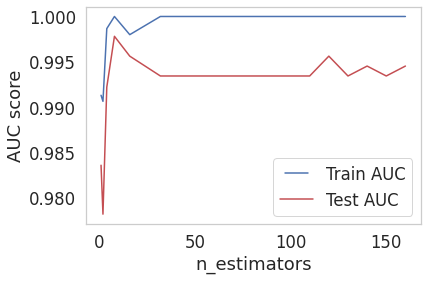

In [23]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 110, 120, 130, 140, 150, 160]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator)
    rf.fit(X_rs, y_rs)
    train_pred = rf.predict(X_rs)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_rs, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.grid(False)
plt.show()

------
Analyzing the permutation importance of the features provided to the model.

In [24]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_rs, y_rs)

RandomForestClassifier(n_estimators=20)

In [25]:
results = permutation_importance(rf, X_rs, y_rs, scoring='accuracy')

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00040
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00027
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00080
Feature: 6, Score: 0.00121
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00080
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00067
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00121
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.43432
Feature: 21, Score: 0.20027
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00080
Feature: 24, Score: 0.00255
Feature: 25, Score: 0.00027


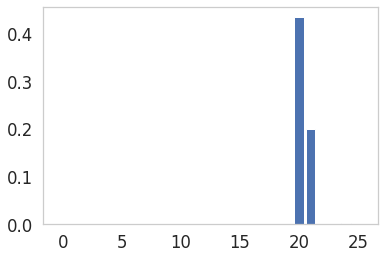

In [26]:
importance = results.importances_mean

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.grid(False)
plt.show()

In [27]:
ml_df.columns[25]

'Volt_21_Value'